In [1]:
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(microbiome)
library(phyloseq)
library(dplyr)
library(WGCNA)

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘WGCNA’ was built under R version 4.1.0”
Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [2]:
# Read in the 16S qza files and clean them up for phyloseq
ASVtable_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/tableV_BacArc_99_SCTLD.qza")
ASVtable_16S <- ASVtable_16S$data # Extract the count data from list
ASVtaxa_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/taxaVsearch_rep-seqs-dn-99_SCTLD.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) 
# Convert taxonomy info to data frame with correct taxonomy labels
taxtable_16S <- taxtable_16S[-1,]
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 70468 rows [2, 7, 11, 13, 15, 17, 21, 23, 27, 29, 34, 38, 39, 41, 43, 46, 47, 50, 54, 56, ...].”


In [3]:
sample_info_tab_16S <- read.csv("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/metadata_for_qiime/SCTLD_meta_analysis_metadata.csv", header = T, row.names = 1,
na.strings = c("", "NA"))

In [4]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [5]:
sub_samples = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton", "Seawater", "Sediment")

sub_samples2 = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton")

ps.coral =subset_samples(physeq_16S, sample_type %in% sub_samples2 & Alias!="AcroporaDisease"
                       )

ps.coral



phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [6]:
ps.coral = filter_taxa(ps.coral, function(x) sum(x > 0) > (0.10*length(x)), TRUE)
ps.coral
ps.coral_clr <- microbiome::transform(ps.coral, 'clr')

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 700 taxa and 1937 samples ]
sample_data() Sample Data:       [ 1937 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 700 taxa by 8 taxonomic ranks ]

In [7]:
?pickSoftThreshold

In [8]:
# Choose a set of soft-thresholding powers
powers <- c(c(1:10), seq(from = 12, to=20, by=2))
sft <- pickSoftThreshold(otu_table(t(ps.coral_clr)), powerVector = powers, verbose = 5, networkType = "unsigned",)


pickSoftThreshold: will use block size 700.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 700 of 700


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.0247 -0.211        0.98600 110.0000  1.05e+02 208.000
2      2   0.6910 -0.942        0.97900  28.3000  2.40e+01  83.000
3      3   0.9110 -1.210        0.99100   9.7400  6.63e+00  41.000
4      4   0.9580 -1.280        0.97800   4.1400  2.09e+00  23.600
5      5   0.9520 -1.280        0.95600   2.0600  7.31e-01  15.100
6      6   0.9530 -1.240        0.95500   1.1400  2.83e-01  10.400
7      7   0.9660 -1.200        0.97000   0.6870  1.22e-01   7.450
8      8   0.9300 -1.200        0.93400   0.4370  5.11e-02   5.510
9      9   0.8940 -1.210        0.88800   0.2890  2.27e-02   4.150
10    10   0.9170 -1.190        0.89700   0.1970  1.01e-02   3.170
11    12   0.8830 -1.180        0.85400   0.0987  2.34e-03   1.940
12    14   0.8980 -1.200        0.87000   0.0530  5.63e-04   1.310
13    16   0.9320 -1.230        0.91900   0.0300  1.32e-04   0.906
14    18   0.2100 -1.640       -0.00903   0.0177  3.12e-05   0

In [9]:
# Plot the results:
sizeGrWindow(9, 5)
par(mfrow = c(1,2))

# Set some parameters
cex1 = 0.9

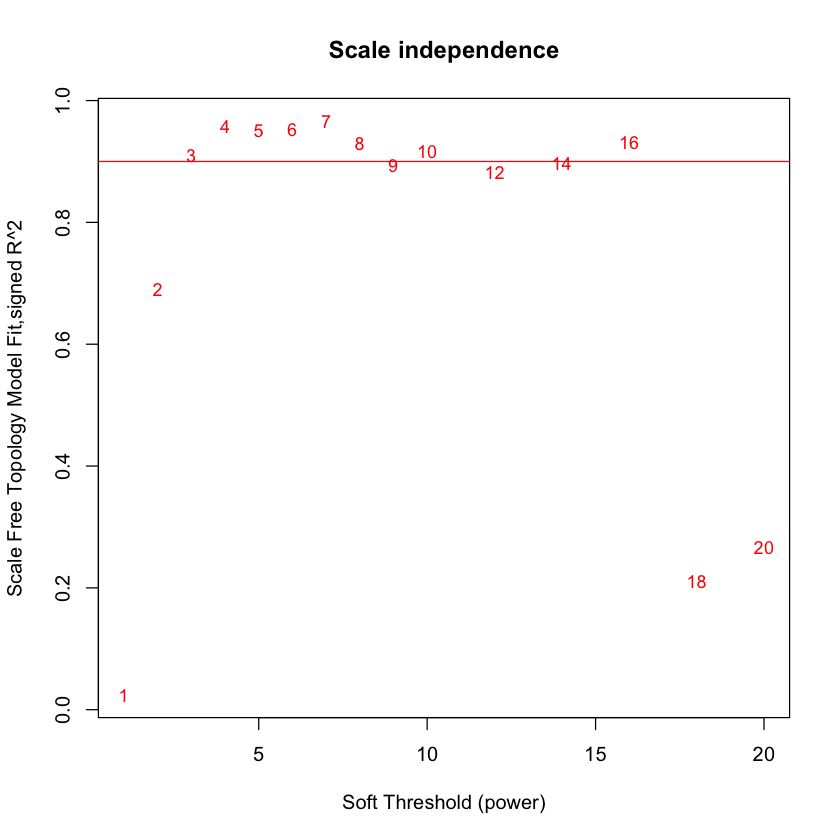

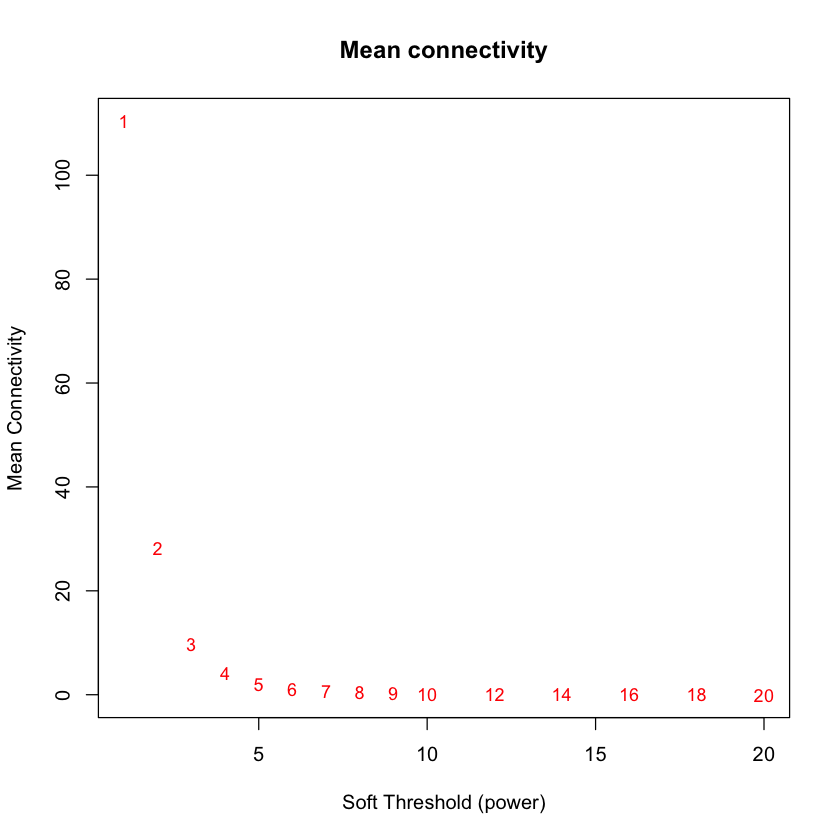

In [10]:

# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2], 
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n", 
     main = paste("Scale independence"))

text(sft$fitIndices[,1], -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")

# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")

# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5], 
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [11]:
# Turn adjacency into topological overlap matrix (TOM)
adjacency <- adjacency(otu_table(t(ps.coral_clr)), power = 3)
TOMadj <- TOMsimilarity(adjacency)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [12]:
?TOMsimilarity

In [13]:
dissTOMadj <- 1- TOMadj


# Clustering using TOM
# Call the hierarchical clustering function 
hclustGeneTree <- hclust(as.dist(dissTOMadj), method = "average")

# Plot the resulting clustering tree (dendogram)
sizeGrWindow(12, 9)


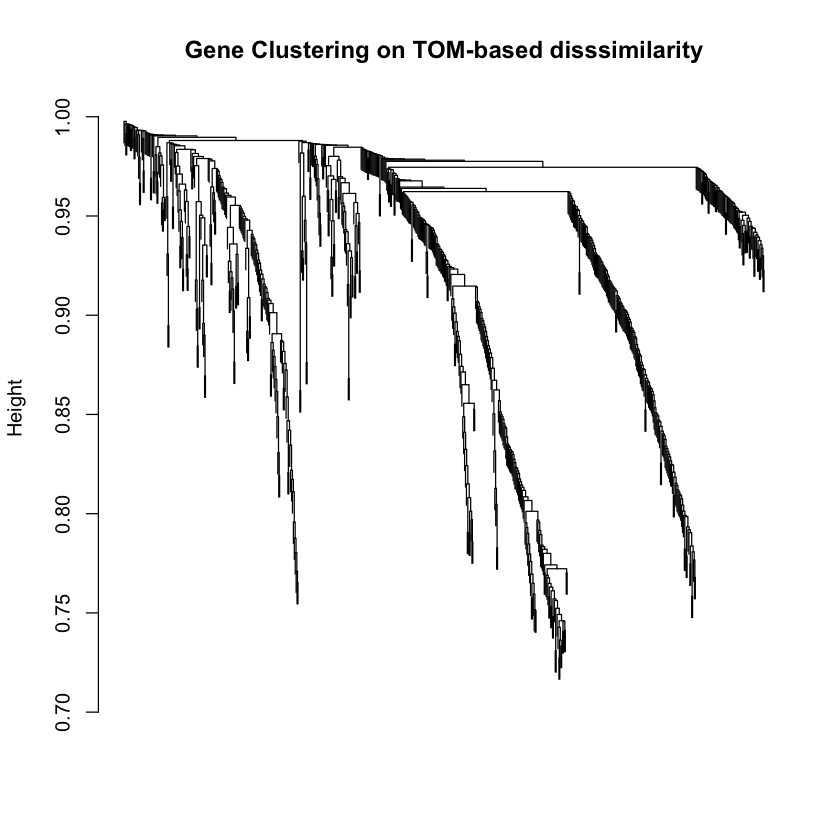

In [14]:
plot(hclustGeneTree, xlab = "", sub = "", 
     main = "Gene Clustering on TOM-based disssimilarity", 
     labels = FALSE, hang = 0.04)


In [15]:
# Make the modules larger, so set the minimum higher
minModuleSize <- 12

# Module ID using dynamic tree cut
dynamicMods <- cutreeDynamic(dendro = hclustGeneTree, 
                             distM = dissTOMadj,
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)

 ..cutHeight not given, setting it to 0.995  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [16]:
dynamicColors <- labels2colors(dynamicMods)
table(dynamicColors)

dynamicColors
    black      blue     brown     green   magenta      pink    purple       red 
       30       162        87        80        18        18        15        38 
turquoise    yellow 
      169        83 

In [17]:
# Plot the dendrogram and colors underneath
sizeGrWindow(8,6)

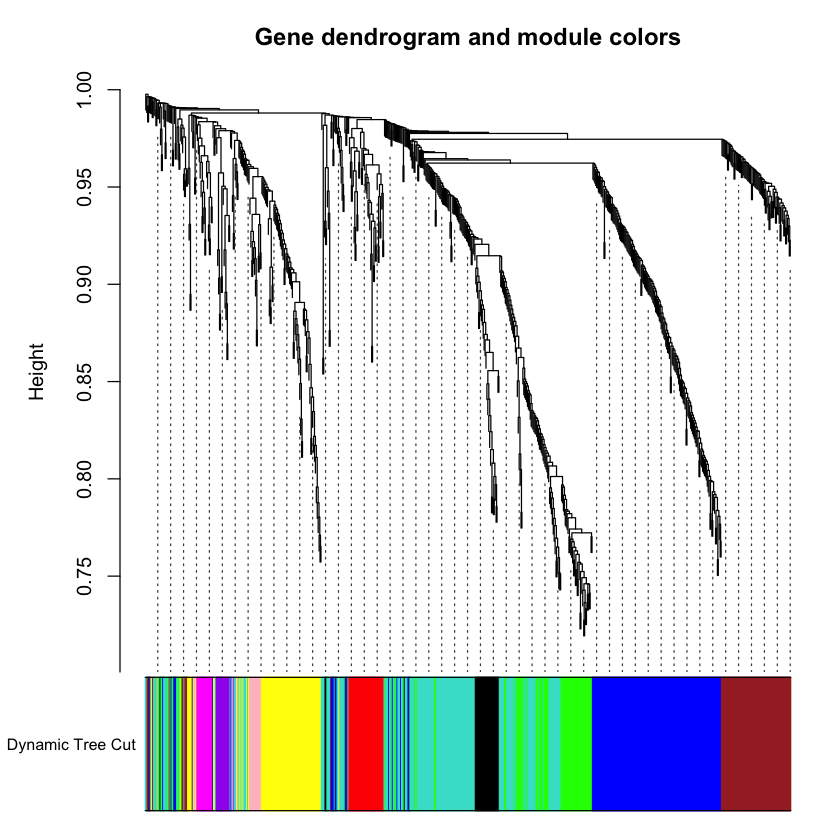

In [18]:

plotDendroAndColors(hclustGeneTree, dynamicColors, "Dynamic Tree Cut", 
                    dendroLabels = FALSE, hang = 0.03, 
                    addGuide = TRUE, guideHang = 0.05, 
                    main = "Gene dendrogram and module colors")


In [19]:
dynamic_MEList <- moduleEigengenes(otu_table(t(ps.coral_clr)), colors = dynamicColors)
dynamic_MEs <- dynamic_MEList$eigengenes

dynamic_MEs <- dynamic_MEs %>%
as.data.frame() #%>%
#select(-MEgrey)

# Calculate dissimilarity of module eigengenes
dynamic_MEDiss <- 1-cor(dynamic_MEs)
dynamic_METree <- hclust(as.dist(dynamic_MEDiss))
# Plot the hclust
sizeGrWindow(7,6)


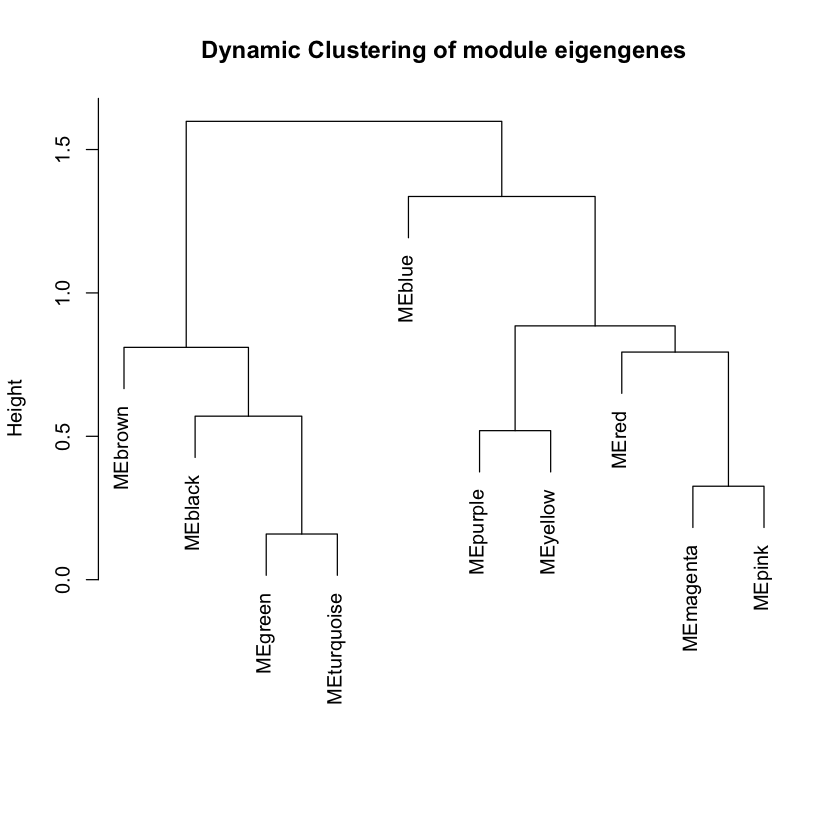

In [20]:
plot(dynamic_METree, main = "Dynamic Clustering of module eigengenes",
     xlab = "", sub = "")

In [21]:
######################## MERGE SIMILAR MODULES
dynamic_MEDissThres <- 0.25

# Plot the cut line
#abline(h = dynamic_MEDissThres, col = "red")

# Call an automatic merging function
merge_dynamic_MEDs <- mergeCloseModules(otu_table(t(ps.coral_clr)), dynamicColors, cutHeight = dynamic_MEDissThres, verbose = 3)



 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 9 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 9 module eigengenes in given set.


In [22]:
# The Merged Colors
dynamic_mergedColors <- merge_dynamic_MEDs$colors

# Eigen genes of the new merged modules
mergedMEs <- merge_dynamic_MEDs$newMEs
head(mergedMEs)

table(dynamic_mergedColors)


,MEbrown,MEblack,MEgreen,MEblue,MEpurple,MEyellow,MEred,MEmagenta,MEpink
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102tiss_S3,-0.002484689,-0.010519727,0.037151583,-0.010161849,-0.012768178,-0.012299381,-0.009186892,-0.010240540,-0.011744525
220tiss_S33,-0.013314203,-0.005547568,0.041330141,-0.010383153,0.001336782,-0.007824524,-0.002191868,-0.007825232,-0.003704197
222tiss_S34,-0.004939102,-0.007651436,0.001585034,-0.003049845,-0.004509707,0.003322919,0.005001947,0.041418271,0.058673741
225tis_S40,-0.004953058,-0.006320921,0.001547347,-0.002786167,-0.001130337,0.001295429,0.004287302,0.051854169,0.055770408
232tiss_S41,-0.013618942,-0.002593961,0.046980900,-0.011975345,0.003170749,-0.009576524,-0.013151494,-0.016070640,-0.011861759
262tiss_S35,-0.014042487,-0.013804140,-0.001444034,-0.009249601,-0.007084080,-0.003378816,0.031943047,0.066905532,0.038247474


dynamic_mergedColors
  black    blue   brown   green magenta    pink  purple     red  yellow 
     30     162      87     249      18      18      15      38      83 

In [23]:
sizeGrWindow(12,9)

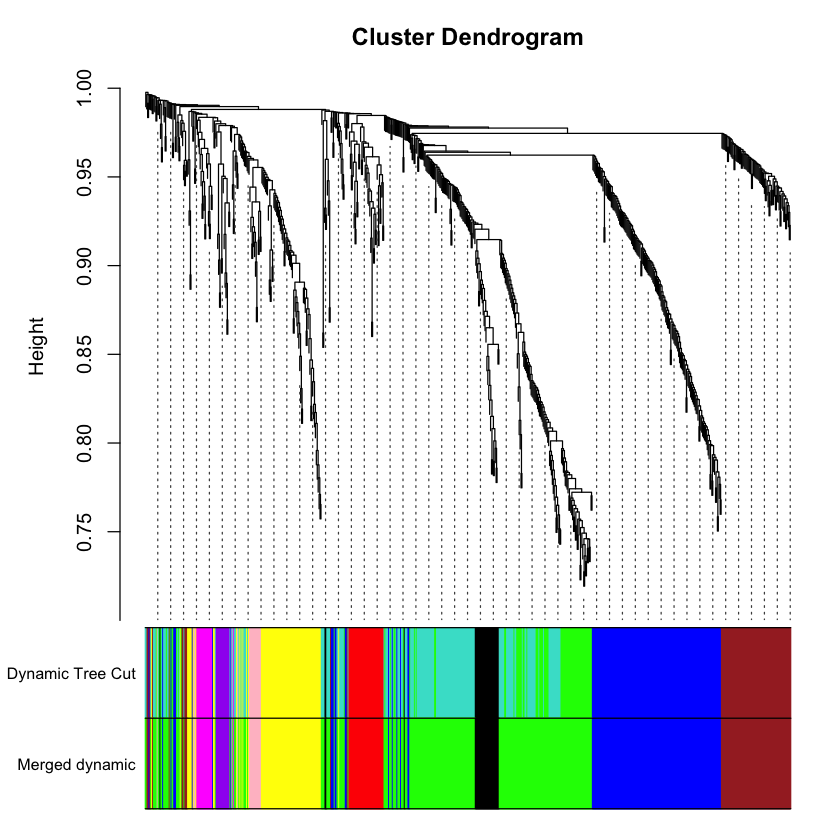

In [24]:

plotDendroAndColors(hclustGeneTree, cbind(dynamicColors, dynamic_mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                      dendroLabels = FALSE, hang = 0.03,
                      addGuide = TRUE, guideHang = 0.05)

In [25]:
# Rename Module Colors 
moduleColors <- dynamic_mergedColors

# Construct numerical labels corresponding to the colors 
colorOrder <- c("grey", standardColors(50))
moduleLabels <- match(moduleColors, colorOrder)-1
MEs <- mergedMEs

In [26]:
dim(sample_data(ps.coral_clr))
dim((otu_table(ps.coral_clr)))

[1] 1937   68

[1]  700 1937

In [27]:
dim(otu_table(t(ps.coral_clr)))
ps_clr_meta= as(sample_data(ps.coral_clr), "data.frame")%>%
select(AH, DU, DL)

[1] 1937  700

In [28]:
head(MEs)
head(ps_clr_meta$tissue_type)

dim(MEs)
dim(ps_clr_meta)

,MEbrown,MEblack,MEgreen,MEblue,MEpurple,MEyellow,MEred,MEmagenta,MEpink
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102tiss_S3,-0.002484689,-0.010519727,0.037151583,-0.010161849,-0.012768178,-0.012299381,-0.009186892,-0.010240540,-0.011744525
220tiss_S33,-0.013314203,-0.005547568,0.041330141,-0.010383153,0.001336782,-0.007824524,-0.002191868,-0.007825232,-0.003704197
222tiss_S34,-0.004939102,-0.007651436,0.001585034,-0.003049845,-0.004509707,0.003322919,0.005001947,0.041418271,0.058673741
225tis_S40,-0.004953058,-0.006320921,0.001547347,-0.002786167,-0.001130337,0.001295429,0.004287302,0.051854169,0.055770408
232tiss_S41,-0.013618942,-0.002593961,0.046980900,-0.011975345,0.003170749,-0.009576524,-0.013151494,-0.016070640,-0.011861759
262tiss_S35,-0.014042487,-0.013804140,-0.001444034,-0.009249601,-0.007084080,-0.003378816,0.031943047,0.066905532,0.038247474


NULL

[1] 1937    9

[1] 1937    3

In [29]:
dim(ps_clr_meta)

[1] 1937    3

In [30]:
cor(MEs, ps_clr_meta$tissue_type_num, use = "p")


,MEbrown,MEblack,MEgreen,MEblue,MEpurple,MEyellow,MEred,MEmagenta,MEpink
MEbrown,1.0000000,0.42498039,0.3523560,-0.59444969,-0.22462529,-0.3770621,-0.3907631,-0.1885688,-0.12631581
MEblack,0.4249804,1.00000000,0.6300798,-0.50811706,-0.21835633,-0.3075279,-0.3946524,-0.1973181,-0.03405202
MEgreen,0.3523560,0.63007978,1.0000000,-0.55515324,-0.25450247,-0.4041290,-0.3662671,-0.2239350,-0.26611693
MEblue,-0.5944497,-0.50811706,-0.5551532,1.00000000,-0.02689774,-0.1671682,0.1821820,-0.2180508,-0.33630786
MEpurple,-0.2246253,-0.21835633,-0.2545025,-0.02689774,1.00000000,0.4803223,0.1688246,0.1908519,0.17667688
MEyellow,-0.3770621,-0.30752791,-0.4041290,-0.16716817,0.48032233,1.0000000,0.1149337,0.3684032,0.59069118
MEred,-0.3907631,-0.39465240,-0.3662671,0.18218201,0.16882463,0.1149337,1.0000000,0.5746208,0.20626463
MEmagenta,-0.1885688,-0.19731806,-0.2239350,-0.21805080,0.19085189,0.3684032,0.5746208,1.0000000,0.67408259
MEpink,-0.1263158,-0.03405202,-0.2661169,-0.33630786,0.17667688,0.5906912,0.2062646,0.6740826,1.00000000


In [31]:
nOTUs <- ncol(otu_table(t(ps.coral_clr)))
nSamples <- nrow(otu_table(t(ps.coral_clr)))

MEs0 <- moduleEigengenes(otu_table(t(ps.coral_clr)), moduleColors)$eigengenes
MEs <- orderMEs(MEs0)

moduleTraitCor= cor(MEs, ps_clr_meta, use = "p")
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples)

In [32]:
head(MEs0)

,MEblack,MEblue,MEbrown,MEgreen,MEmagenta,MEpink,MEpurple,MEred,MEyellow
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102tiss_S3,-0.010519727,-0.010161849,-0.002484689,0.037151583,-0.010240540,-0.011744525,-0.012768178,-0.009186892,-0.012299381
220tiss_S33,-0.005547568,-0.010383153,-0.013314203,0.041330141,-0.007825232,-0.003704197,0.001336782,-0.002191868,-0.007824524
222tiss_S34,-0.007651436,-0.003049845,-0.004939102,0.001585034,0.041418271,0.058673741,-0.004509707,0.005001947,0.003322919
225tis_S40,-0.006320921,-0.002786167,-0.004953058,0.001547347,0.051854169,0.055770408,-0.001130337,0.004287302,0.001295429
232tiss_S41,-0.002593961,-0.011975345,-0.013618942,0.046980900,-0.016070640,-0.011861759,0.003170749,-0.013151494,-0.009576524
262tiss_S35,-0.013804140,-0.009249601,-0.014042487,-0.001444034,0.066905532,0.038247474,-0.007084080,0.031943047,-0.003378816


In [33]:
moduleTraitPvalue

,AH,DU,DL
MEbrown,8.731519e-02,1.885584e-07,2.044089e-02
MEblack,1.000442e-07,1.756708e-43,3.166356e-07
MEgreen,1.847070e-04,6.695215e-100,2.157428e-34
MEblue,3.224603e-32,1.667054e-28,2.192746e-04
MEpurple,9.626854e-06,8.847221e-11,6.642556e-01
MEyellow,7.131953e-03,1.272780e-09,9.577570e-15
MEred,3.350538e-01,2.919902e-29,2.181043e-23
MEmagenta,2.236612e-41,1.165140e-14,4.005517e-101
MEpink,1.393034e-57,3.720887e-07,1.173567e-105


In [34]:
moduleTraitCor

,AH,DU,DL
MEbrown,-0.03885796,0.1180469,-0.052669181
MEblack,-0.12066427,0.3067575,-0.115863916
MEgreen,-0.08485829,0.4556357,-0.272766290
MEblue,0.26387543,-0.2478532,-0.083877825
MEpurple,0.10036189,-0.1466556,0.009868247
MEyellow,-0.06111695,-0.1373713,0.174728898
MEred,-0.02191459,-0.2512108,0.223675998
MEmagenta,-0.29928848,-0.1741748,0.458151384
MEpink,-0.35195643,-0.1151761,0.467295436


In [35]:
ps_clr_meta$tissue_type
names(MEs)

NULL

[1] "MEbrown"   "MEblack"   "MEgreen"   "MEblue"    "MEpurple"  "MEyellow" 
[7] "MEred"     "MEmagenta" "MEpink"

In [37]:
# PLOT
sizeGrWindow(10,6)
textMatrix <- paste(signif(moduleTraitCor, 2), "\n(", signif(moduleTraitPvalue, 1), ")", sep = "")
dim(textMatrix) <- dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3))

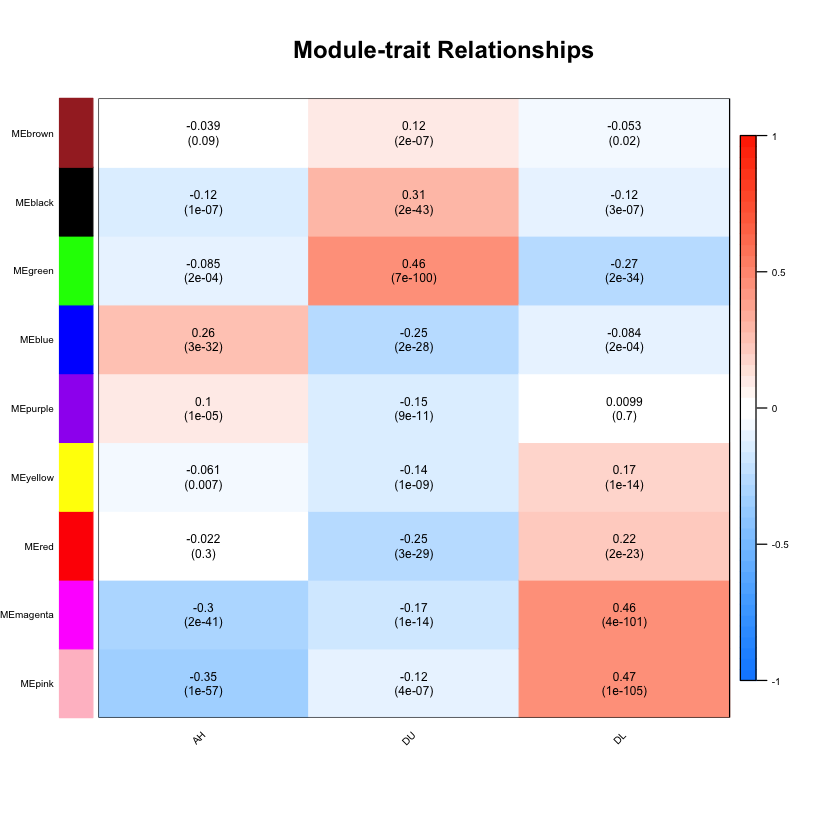

In [39]:
labeledHeatmap(Matrix = moduleTraitCor, 
               xLabels = names(ps_clr_meta),
               yLabels = names(MEs), 
               ySymbols = names(MEs), 
               colorLabels = FALSE, 
               colors = blueWhiteRed(50),
               textMatrix = textMatrix, 
               setStdMargins = FALSE,
               cex.text = 0.6,
               cex.lab=0.5,
               zlim = c(-1,1),
               main = paste("Module-trait Relationships"))

In [40]:
jpeg("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/Module.jpeg", width = 6, height = 5,
     units = 'in', res = 300)

# Display the correlation values within a heatmap
labeledHeatmap(Matrix = moduleTraitCor, 
               xLabels = names(ps_clr_meta),
               yLabels = names(MEs), 
               ySymbols = names(MEs), 
               colorLabels = FALSE, 
               colors = blueWhiteRed(50),
               textMatrix = textMatrix, 
               setStdMargins = FALSE,
               cex.text = 0.6,
               cex.lab=0.5,
               zlim = c(-1,1),
               main = paste("Module-trait Relationships"))
dev.off()

pdf 
  2

In [41]:
geneModuleMembership <- as.data.frame(WGCNA::cor(otu_table(t(ps.coral_clr)), MEs, use = "p"))

In [42]:
geneModuleMembership <- as.data.frame(WGCNA::cor(otu_table(t(ps.coral_clr)), MEs, use = "p"))
# What are the p-values for each correlation?
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

# What's the correlation for the trait: bacterial production?
geneTraitSignificance <- as.data.frame(cor(otu_table(t(ps.coral_clr)), ps_clr_meta, use = "p"))

# What are the p-values for each correlation?
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples = nSamples))

names(geneTraitSignificance) <- paste("GS.", names(ps_clr_meta), sep = "")
names(GSPvalue) <- paste("p.GS.", names(ps_clr_meta), sep = "")

In [43]:
head(geneModuleMembership)
dim(geneModuleMembership)
head(GSPvalue)
dim(GSPvalue)

,MEbrown,MEblack,MEgreen,MEblue,MEpurple,MEyellow,MEred,MEmagenta,MEpink
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
944c108b6e81ffecad1fda219fbe53f9,0.02925153,0.17039075,0.07296235,0.05248614,0.196921671,-0.20923930,-0.009822501,-0.02480985,-0.112809645
338fbecfaa49ac040aca66eab179b62f,-0.32499966,-0.26307181,-0.26669027,0.22708479,0.182129719,0.26211574,0.215898314,0.19130355,0.177486706
a8412eaf88b7b351a096ce924639f628,-0.13986931,-0.09071535,0.06668012,-0.01965957,-0.002694423,0.01218688,0.187187002,0.11475216,0.004407302
b12f1ebb5d05e1c88a9f265adb80fc55,-0.15712609,-0.21714753,-0.36057044,-0.03015685,0.003137478,0.35005791,0.104365676,0.33972631,0.386100667
1bc3d9cd57c6838583bb658b3003caa1,-0.09888018,-0.16606133,-0.24951542,-0.06576398,0.225384128,0.46253469,-0.045981780,0.09839831,0.158565939
5ea4e6d172010676d104e0d06b74eb20,0.34953325,0.66027368,0.83497112,-0.51803064,-0.312232349,-0.37787589,-0.373995669,-0.21325336,-0.181762918


[1] 700   9

,p.GS.AH,p.GS.DU,p.GS.DL
,<dbl>,<dbl>,<dbl>
944c108b6e81ffecad1fda219fbe53f9,1.091438e-05,1.196492e-01,5.709052e-04
338fbecfaa49ac040aca66eab179b62f,1.284825e-02,4.636970e-05,5.560087e-01
a8412eaf88b7b351a096ce924639f628,7.568219e-01,1.088835e-05,1.512480e-03
b12f1ebb5d05e1c88a9f265adb80fc55,1.445309e-20,7.385765e-18,1.130330e-66
1bc3d9cd57c6838583bb658b3003caa1,1.876925e-01,4.810052e-07,5.758890e-08
5ea4e6d172010676d104e0d06b74eb20,2.048975e-12,7.445795e-90,4.755270e-15


[1] 700   3

In [44]:
# Combine pval, taxonomy, module membership, and gene significance into one dataframe

# Prepare pvalue df
GSpval <- GSPvalue %>%
  tibble::rownames_to_column(var = "OTU")

# Prepare taxonomy df
tax_df <- tax_table(ps.coral) %>%
  data.frame() %>%
  tibble::rownames_to_column(var = "OTU") #%>%
  #rename(Domain = Rank1, Phylum = Rank2, Class = Rank3, Order = Rank4, Family = Rank5, Genus = Rank6, Species = Rank7)

# Prepare module membership df
# Modify column names
#names(geneModuleMembership) <- substring(names(geneModuleMembership), 3)

gMM_df <- geneModuleMembership %>%
  tibble::rownames_to_column(var = "OTU") %>%
  gather(key = "moduleColor", value = "moduleMemberCorr", -OTU) 

# Prepare gene significance df
GS_bacprod_df <- geneTraitSignificance %>%
  data.frame() %>%
  tibble::rownames_to_column(var = "OTU")

# Put everything together 
allData_df <- gMM_df %>%
  left_join(GS_bacprod_df, by = "OTU") %>%
  left_join(GSpval, by = "OTU") %>%
  left_join(tax_df, by = "OTU")

In [45]:

magenta =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.1) %>%
filter(moduleColor=="MEmagenta") %>%
arrange(-moduleMemberCorr) %>%
select(OTU) %>%
as.matrix()
dim(magenta)
head(magenta)


pink =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.1) %>%
filter(moduleColor=="MEpink") %>%
arrange(-moduleMemberCorr) %>%
select(OTU) %>%
as.matrix()
dim(pink)
head(pink)



green =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.2) %>%
filter(moduleColor=="MEgreen") %>%
arrange(-moduleMemberCorr) %>%
select(OTU) %>%
as.matrix()
dim(green)
head(green)


blue =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.2) %>%
filter(moduleColor=="MEblue") %>%
arrange(-moduleMemberCorr) %>%
select(OTU) %>%
as.matrix()
dim(blue)
head(blue)


[1] 159   1

OTU
a08193ab3e8a00e6a7a5df55de6a3f2c
b0ea8ed850dfa79f3e0a3136acfd6811
e91a05749828bd0c8e886fd459155a40
dcfed4c1f56f71124da2676189647e3e
429264bc3cd49d9c544f286870123eaa
a41ce4b6f4fe0c5a32c555f986280c11


[1] 146   1

OTU
86dbcbba6c57d3beb084182c8f520b60
6e519ef6ff86850c277d3f4ad53bc951
e9c4b7e7d99e80582286a76f283bb017
30a71a54072b391cd6c1fde236528f9d
9348f8a8c78d7f64453ffd1185e6ae85
7028764c40328ee367523bc766d3e82c


[1] 158   1

OTU
293e3bc035269ee105768b681be3f107
cd8d8260ff21fcaf097dfe1fa7df833d
bd006189eeaf9417d30647a5c2474d06
dab22d10f7b65d9822ef6be327f14265
bcb850209fde2b286a1b06dc0f150b61
15724e4ebde7539ae4e4b971393aa70e


[1] 134   1

OTU
dc0397dd3a1c7e213e3c878fda06855c
00a346adeb06f21cfc679d976f159ba1
6819d64aedc089ee2e81dbe0704044cd
f0b924033f528ea054ac90742629597e
7f0d425937c3d9f8182d6e24173cdb6e
aa8e1e26164fee4f3bec1e1feda82833


In [46]:
allTaxa = taxa_names(ps.coral)
allTaxa <- allTaxa[(allTaxa %in% magenta)]
ps_magenta=prune_taxa(allTaxa, ps.coral)

allTaxa = taxa_names(ps.coral)
allTaxa <- allTaxa[(allTaxa %in% pink)]
ps_pink=prune_taxa(allTaxa, ps.coral)

allTaxa = taxa_names(ps.coral)
allTaxa <- allTaxa[(allTaxa %in% green)]
ps_green=prune_taxa(allTaxa, ps.coral)

allTaxa = taxa_names(ps.coral)
allTaxa <- allTaxa[(allTaxa %in% blue)]
ps_blue=prune_taxa(allTaxa, ps.coral)

In [47]:
library(DT)

# Module Membership
mm_df <- geneModuleMembership %>%
  tibble::rownames_to_column(var = "OTU") %>%
  mutate(blue = round(abs(MEmagenta), digits = 3), 
         green = round(abs(MEpink), digits = 3),  
         brown = round(abs(MEred), digits = 3), 
         turquoise = round(abs(MEgreen), digits = 3),  
         yellow = round(abs(MEyellow), digits = 3)) %>%
  left_join(tax_df, by = "OTU")

In [48]:
#import libraries for network analysis
library("SpiecEasi"); packageVersion("SpiecEasi")
library(igraph) ; packageVersion("igraph")
library("ggraph")
library("influenceR") ; packageVersion("influenceR")
library(tidygraph)
library(tidyverse) ; packageVersion("tidyverse")

[1] ‘1.1.2’


Attaching package: ‘igraph’


The following object is masked from ‘package:SpiecEasi’:

    make_graph


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:microbiome’:

    diversity


The following object is masked from ‘package:tibble’:

    as_data_frame


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




[1] ‘1.3.0’


Attaching package: ‘influenceR’


The following objects are masked from ‘package:igraph’:

    betweenness, constraint




[1] ‘0.1.0.1’


Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha()     masks ggplot2::alpha()
✖ igraph::as_data_frame() masks dplyr::as_data_frame(), tibble::as_data_frame()
✖ purrr::compose()        masks igraph::compose()
✖ igraph::crossing()      masks tidyr::crossing()
✖ tidygraph::filter()     masks dplyr::filter(), stats::filter()
✖ tidygraph::groups()     masks igraph::groups(), dplyr::groups()
✖ dplyr::lag()            masks stats::lag()
✖ purrr::simplify()       masks igraph::simplify()



[1] ‘1.3.1’

In [49]:
ps_magenta_DL =subset_samples(ps_magenta, tissue_type=="DL")
ps_magenta_DL

ps_pink_DL =subset_samples(ps_pink, tissue_type=="DL")
ps_pink_DL

ps_green_DU =subset_samples(ps_green, tissue_type=="DU")
ps_green_DU

ps_blue_AH =subset_samples(ps_blue, tissue_type=="AH")
ps_blue_AH

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 159 taxa and 631 samples ]
sample_data() Sample Data:       [ 631 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 159 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 146 taxa and 631 samples ]
sample_data() Sample Data:       [ 631 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 146 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 158 taxa and 325 samples ]
sample_data() Sample Data:       [ 325 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 158 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 134 taxa and 981 samples ]
sample_data() Sample Data:       [ 981 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 134 taxa by 8 taxonomic ranks ]

In [50]:
# Perform SPIEC_EASI on diseased lesions
pink_DL <- ps_pink_DL %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_pink_DL <- adj2igraph(getRefit(pink_DL), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_pink_DL)))

tbl_pink_DL=as_tbl_graph(ig_pink_DL)
tbl_pink_DL

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



# A tbl_graph: 123 nodes and 204 edges
#
# An undirected simple graph with 3 components
#
# Node Data: 123 × 1 (active)
  name                            
  <chr>                           
1 b12f1ebb5d05e1c88a9f265adb80fc55
2 1bc3d9cd57c6838583bb658b3003caa1
3 7df259fe05818b722e6f40845a657dc8
4 c6b98c58f5a8f184cc1b130f66f944ab
5 7b737017b8a2a3a5f051e9b9944fa6ab
6 f99b1bb6babe435d233f113a87bc258f
# … with 117 more rows
#
# Edge Data: 204 × 3
   from    to weight
  <int> <int>  <dbl>
1     1     3      1
2     1    83      1
3     2    11      1
# … with 201 more rows

In [51]:
# Perform SPIEC_EASI on diseased lesions
green_DU <- ps_green_DU %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_green_DU <- adj2igraph(getRefit(green_DU), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_green_DU)))

tbl_green_DU=as_tbl_graph(ig_green_DU)
tbl_green_DU

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



# A tbl_graph: 138 nodes and 293 edges
#
# An undirected simple graph with 2 components
#
# Node Data: 138 × 1 (active)
  name                            
  <chr>                           
1 5ea4e6d172010676d104e0d06b74eb20
2 ca349f9a464af37e05d4e51c6a162ba3
3 c9ec8d7403b1ce7a8e1661e6f4dc5646
4 b975781cd72ba73e56de1fd07ec52117
5 df84a5521a71e034423dee45569b5796
6 6889bec81abb3a6fecd845322e21be4f
# … with 132 more rows
#
# Edge Data: 293 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    15      1
2     1    18      1
3     1    20      1
# … with 290 more rows

In [52]:
# Perform SPIEC_EASI on diseased lesions
blue_AH <- ps_blue_AH %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_blue_AH <- adj2igraph(getRefit(blue_AH ), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_blue_AH)))

tbl_blue_AH=as_tbl_graph(ig_blue_AH)
tbl_blue_AH

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



# A tbl_graph: 56 nodes and 59 edges
#
# An undirected simple graph with 9 components
#
# Node Data: 56 × 1 (active)
  name                            
  <chr>                           
1 a579e68317aaa6f535939bbd1fa3a624
2 f0b924033f528ea054ac90742629597e
3 e940a809fced8315bd27605e01a37633
4 10ca7b37a32911727452c2fe064fca65
5 a9649a6660acb24abe1f402a6504793a
6 145e261d3c909e3076eb59e5f20a3c7d
# … with 50 more rows
#
# Edge Data: 59 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    22      1
2     2     7      1
3     2     8      1
# … with 56 more rows

In [53]:
taxa_df=as.data.frame(taxtable_16S) %>%
rename(name=Feature.ID)

magenta =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.1) %>%
filter(moduleColor=="MEmagenta") %>%
arrange(-moduleMemberCorr) 

alldata_df2=as.data.frame(magenta) %>%
rename(name=OTU)


pink =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.1) %>%
filter(moduleColor=="MEpink") %>%
arrange(-moduleMemberCorr) 

alldata_pink=as.data.frame(pink) %>%
rename(name=OTU)


green =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.2) %>%
filter(moduleColor=="MEgreen") %>%
arrange(-moduleMemberCorr) 

alldata_green=as.data.frame(green) %>%
rename(name=OTU)


blue =allData_df %>%
filter(p.GS.DL <0.05) %>%
filter(moduleMemberCorr>0.2) %>%
filter(moduleColor=="MEblue") %>%
arrange(-moduleMemberCorr) 

alldata_blue=as.data.frame(blue) %>%
rename(name=OTU)

In [54]:
pink_tax=tbl_pink_DL %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(alldata_pink, by="name") %>% 
mutate(
    neighbors = centrality_degree(),
         group = group_infomap(),
         center = node_is_center(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 10),
Health.State="DL") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
  mutate(centrality = centrality_edge_betweenness())


Joining, by = "name"


In [67]:
green_tax=tbl_green_DU %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(alldata_green, by="name") %>% 
mutate(
    neighbors = centrality_degree(),
         group = group_infomap(),
         center = node_is_center(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 10),
 Health.State="ahDU") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
  mutate(centrality = centrality_edge_betweenness())

Joining, by = "name"


In [56]:
blue_tax=tbl_blue_AH %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(alldata_blue, by="name") %>% 
mutate(
    neighbors = centrality_degree(),
         group = group_infomap(),
         center = node_is_center(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 10),
 Health.State="AH") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
  mutate(centrality = centrality_edge_betweenness())

Joining, by = "name"


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in g

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

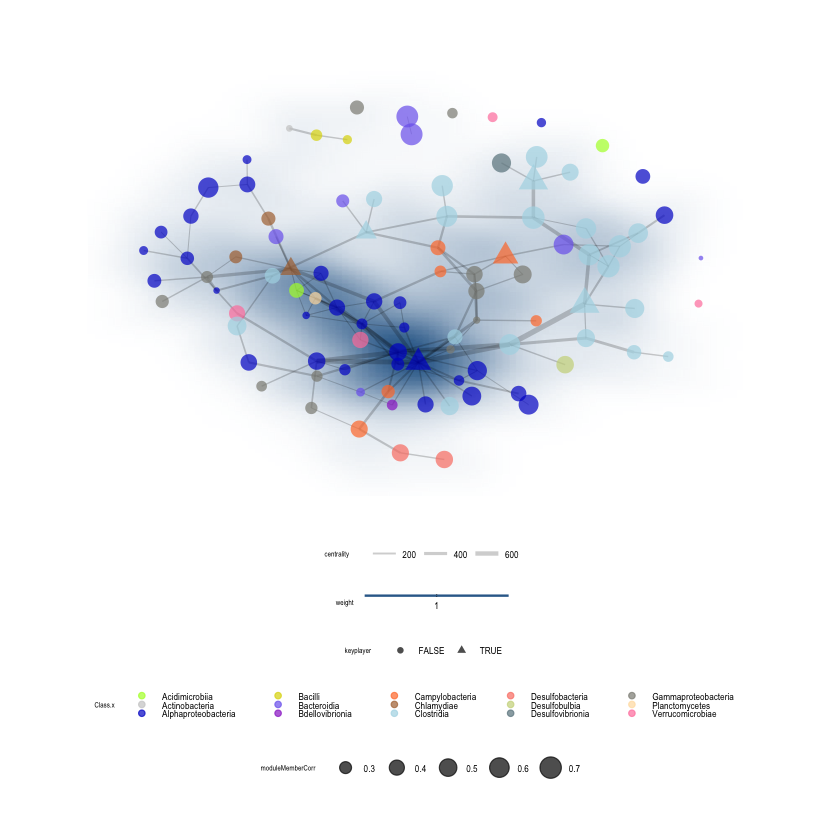

In [57]:
set.seed(101)
pink_tax %>%
activate(nodes) %>%
filter(moduleMemberCorr>0.2) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "f__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "c__",
                replacement = "")  %>%
ggraph(layout = "fr") + 
      geom_edge_density(aes(fill = weight)) +
geom_edge_link(aes(width = centrality), alpha = 0.2) + 
    scale_edge_width_continuous(range=c(0.2,1.5)) +

    geom_node_point(aes(size= moduleMemberCorr, color = Class.x, shape=keyplayer),
                   alpha=0.7) + 

geom_node_text(aes(label = ifelse(Class.x == "Clostridia", as.character(Order.x), "")),
               size = 1.1, ,hjust=.2,vjust=.6) +
guides(fill = guide_legend(keywidth = 0.30, keyheight = 0.40, ncol=5)) +
theme_graph() +
theme(legend.position="bottom", legend.box="vertical") +
theme(legend.text =element_text(size=6)) +
theme(legend.title =element_text(size=4.5)) +
#theme(legend.spacing.y =unit(.10, 'mm')) +
theme(legend.key.height=unit(0.1,"line")) +
scale_color_manual(values=c("#ADFF2F", 
                            "gray80", "#0000CD","#DCD502", "#7B68EE",
                           "darkorchid", "#FF7A33","#AD6F3B",
                          "lightblue", "salmon", "#CBD588",
                           "lightblue4", "ivory4", "#FFDEAD", "palevioletred1",
                            "Navy",
                           "Red","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#E6E6FA",
                          "#5F9EA0", "#6495ED", "#1E90FF" ,"#87CEEB",
                           "#8A2BE2", "#4B0082", "#000080",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                            "gray80", "#0000CD","#DCD502", "#7B68EE",
                           "darkorchid", "#FF7A33","#AD6F3B",
                          "lightblue", "salmon", "#CBD588",
                           "lightblue4", "ivory4", "#FFDEAD", "palevioletred1",
                            "Navy",
                           "Red","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#E6E6FA"))


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/network_pink_class.png",
    width = 5, height = 5, units = "in", dpi=250)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

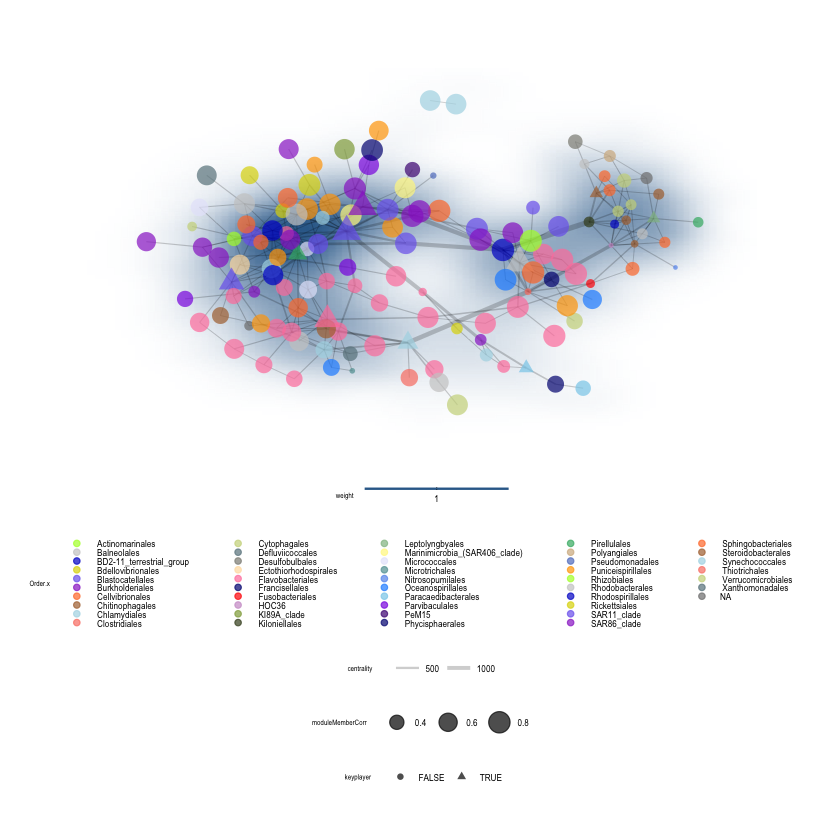

In [58]:
set.seed(101)
green_tax %>%
activate(nodes) %>%
filter(moduleMemberCorr>0.2) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "f__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "c__",
                replacement = "")  %>%
ggraph(layout = "fr") + 
      geom_edge_density(aes(fill = weight)) +
geom_edge_link(aes(width = centrality), alpha = 0.2) + 
    scale_edge_width_continuous(range=c(0.2,1.5)) +

    geom_node_point(aes(size= moduleMemberCorr, color = Order.x, shape=keyplayer),
                   alpha=0.7) + 

geom_node_text(aes(label = ifelse(Class.x == "Clostridia", as.character(Order.x), "")),
               size = 1.1, ,hjust=.2,vjust=.6) +
guides(fill = guide_legend(keywidth = 0.30, keyheight = 0.40, ncol=5)) +
theme_graph() +
theme(legend.position="bottom", legend.box="vertical") +
theme(legend.text =element_text(size=6)) +
theme(legend.title =element_text(size=4.5)) +
#theme(legend.spacing.y =unit(.10, 'mm')) +
theme(legend.key.height=unit(0.1,"line")) +
scale_color_manual(values=c("#ADFF2F", 
                            "gray80", "#0000CD","#DCD502", "#7B68EE",
                           "darkorchid", "#FF7A33","#AD6F3B",
                          "lightblue", "salmon", "#CBD588",
                           "lightblue4", "ivory4", "#FFDEAD", "palevioletred1",
                            "Navy",
                           "Red","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#E6E6FA",
                          "#5F9EA0", "#6495ED", "#1E90FF" ,"#87CEEB",
                           "#8A2BE2", "#4B0082", "#000080",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                            "gray80", "#0000CD","#DCD502", "#7B68EE",
                           "darkorchid", "#FF7A33","#AD6F3B",
                          "lightblue", "salmon", "#CBD588",
                           "lightblue4", "ivory4", "#FFDEAD", "palevioletred1",
                            "Navy",
                           "Red","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#E6E6FA"))


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/network_green_order.png",
    width = 5.5, height = 5, units = "in", dpi=250)

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

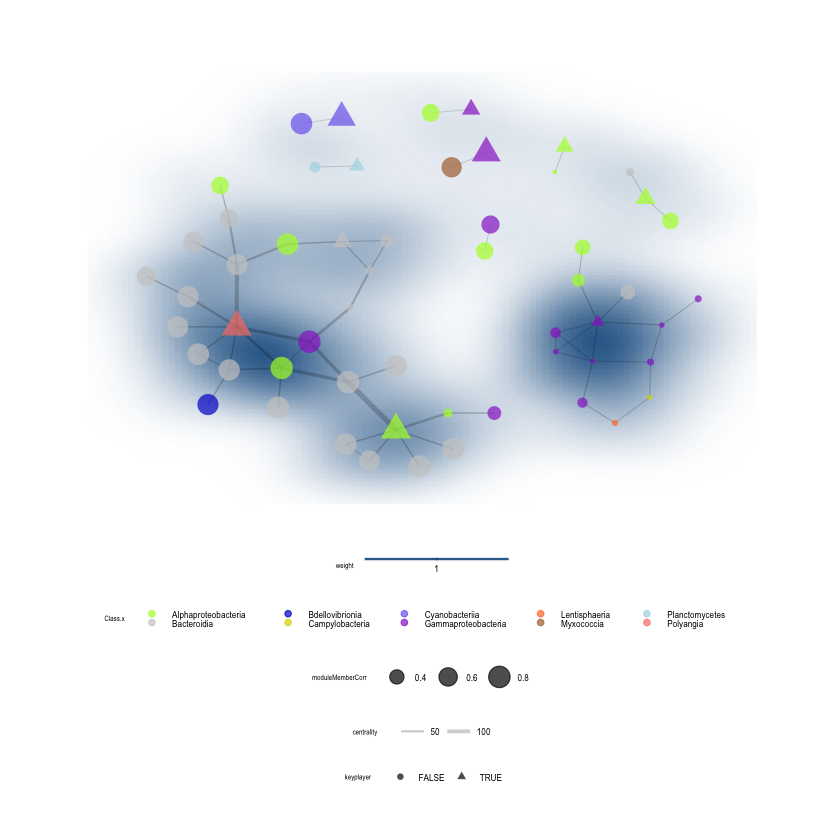

In [59]:
set.seed(101)
blue_tax %>%
activate(nodes) %>%
filter(moduleMemberCorr>0.2) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "f__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "c__",
                replacement = "")  %>%
ggraph(layout = "fr") + 
      geom_edge_density(aes(fill = weight)) +
geom_edge_link(aes(width = centrality), alpha = 0.2) + 
    scale_edge_width_continuous(range=c(0.2,1.5)) +

    geom_node_point(aes(size= moduleMemberCorr, color = Class.x, shape=keyplayer),
                   alpha=0.7) + 

geom_node_text(aes(label = ifelse(Class.x == "Clostridia", as.character(Order.x), "")),
               size = 1.1, ,hjust=.2,vjust=.6) +
guides(fill = guide_legend(keywidth = 0.30, keyheight = 0.40, ncol=5)) +
theme_graph() +
theme(legend.position="bottom", legend.box="vertical") +
theme(legend.text =element_text(size=6)) +
theme(legend.title =element_text(size=4.5)) +
#theme(legend.spacing.y =unit(.10, 'mm')) +
theme(legend.key.height=unit(0.1,"line")) +
scale_color_manual(values=c("#ADFF2F", 
                            "gray80", "#0000CD","#DCD502", "#7B68EE",
                           "darkorchid", "#FF7A33","#AD6F3B",
                          "lightblue", "salmon", "#CBD588",
                           "lightblue4", "ivory4", "#FFDEAD", "palevioletred1",
                            "Navy",
                           "Red","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#E6E6FA",
                          "#5F9EA0", "#6495ED", "#1E90FF" ,"#87CEEB",
                           "#8A2BE2", "#4B0082", "#000080",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                            "gray80", "#0000CD","#DCD502", "#7B68EE",
                           "darkorchid", "#FF7A33","#AD6F3B",
                          "lightblue", "salmon", "#CBD588",
                           "lightblue4", "ivory4", "#FFDEAD", "palevioletred1",
                            "Navy",
                           "Red","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#E6E6FA"))


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/network_blue_class.png",
    width = 5.5, height = 5, units = "in", dpi=250)

In [68]:
combo = green_tax %>% bind_graphs(pink_tax)
combo= combo %>% bind_graphs(blue_tax)


In [69]:
#combine networks
all_combo= combo %>%
activate(nodes) %>% 
mutate(
    neighbors = centrality_degree(),
         group = group_infomap(),
         center = node_is_center(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 10)) %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
  mutate(centrality = centrality_edge_betweenness())  

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial N

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narrow' not found in PostScript font database”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Arial Narr

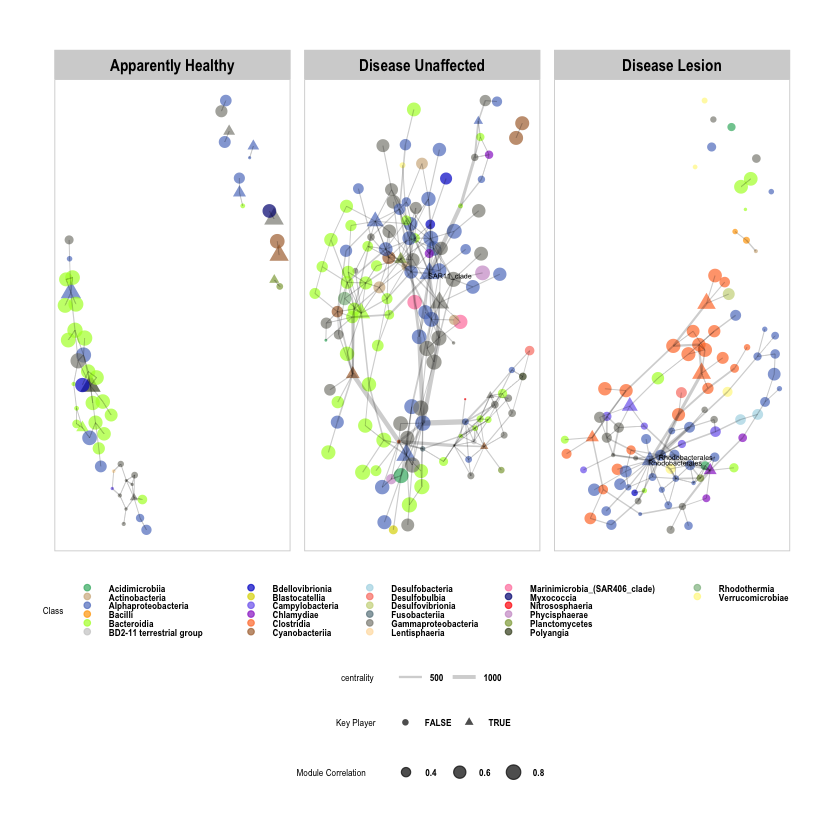

In [118]:
supp.labs <- c("Apparently Healthy", "Disease Unaffected", "Disease Lesion")
names(supp.labs) <- c("AH", "ahDU","DL")


set.seed(101)
combo %>%
activate(nodes) %>%
filter(moduleMemberCorr>0.2) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "c__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_terrestrial_group",
                replacement = " terrestrial group")  %>%

mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "Marinimicrobia_(SAR406_clade)",
                replacement = "Marinimicrobia (SAR406 clade)")  %>%

#fct_relevel(Health.State, "AH", "DU", "DL") %>%
ggraph(layout = "nicely") + 

geom_node_point(aes(size = moduleMemberCorr, color = Class.x, shape=keyplayer, alpha = 0.2),
                   alpha=0.7) + 
geom_node_text(aes(label = ifelse(Class.x == "Alphaproteobacteria", as.character(Order.x), "")),
               size = 1.1, ,hjust=.2,vjust=.6) +
  
geom_node_text(aes(label= Order.x, filter = ( neighbors > 15)) , size = 1.5, hjust=.065,vjust=.9) +


guides(fill = guide_legend(keywidth = 0.30, keyheight = 0.40, ncol=1)) +
      #geom_edge_density(aes(fill = weight)) +
 geom_edge_link(aes(width = centrality), alpha = 0.2) + 
    scale_edge_width_continuous(range=c(0.2,1.5)) +
scale_size(

    range = c(.3, 4)
  ) +
theme_graph() +
theme(legend.position="bottom", legend.box="vertical") +
theme(legend.text =element_text(size=6, face = "bold")) +
theme(legend.title =element_text(size=6)) +
#theme(legend.spacing.y =unit(.10, 'mm')) +
theme(legend.key.height=unit(0.1,"line")) +
scale_color_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                            "gray80", "#0000CD","#DCD502", "#7B68EE",
                           "darkorchid", "#FF7A33","#AD6F3B",
                          "lightblue", "salmon", "#CBD588",
                           "lightblue4", "ivory4", "#FFDEAD", "palevioletred1",
                            "Navy",
                           "Red","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#E6E6FA",
                          "#5F9EA0", "#6495ED", "#1E90FF" ,"#87CEEB",
                           "#8A2BE2", "#4B0082", "#000080")) +
facet_nodes(.~Health.State, scales="free", labeller = labeller(Health.State = supp.labs)) +
th_foreground(foreground = 'lightgrey', border = TRUE) +
labs(color="Class", size="Module Correlation", shape= "Key Player")


ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/network_all.png",
    width = 6.8, height = 5.5, units = "in", dpi=250)